# 2. Studienarbeit in Reinforcement Learning

<a id="0"></a>
 # Gliederung
 
0. [How to run this Notebook](#0)   
1. [Imports](#1)  
2. [Validate & Register Environment](#2) 
3. [Hyperparameter optimization using Optuna](#3) 
    - [Run optimization](#3a)
4. [Model training](#4)
5. [Model Evaluation](#5)
6. [Conclusion](#6)


## How to run this Notebook <a class="anchor" id="0"></a>
1. Create a virtual environment using `python -m  venv /path/to/new/environment`
2. Install Packages from requirements.txt using `pip install -r requirements.txt`

## Imports<a class="anchor" id="1"></a>

In [1]:
%load_ext autoreload
import numpy as np
import matplotlib.pyplot as plt
import optuna
import CurvyRaceEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3 import DDPG,SAC, TD3, A2C, PPO

import gymnasium
from gymnasium.envs.registration import register

import pandas as pd
import optuna

import torch
import torch.nn as nn
import time

%matplotlib inline
%reload_ext autoreload

## Validate & Register Environment<a class="anchor" id="2"></a>


In order to use a custom Environment with gymnasium and stable_baselines3, it needs to be validated and registered. 

In [2]:
test = CurvyRaceEnv.CurvyRaceEnv()
check_env(test)
ENV_ID = "CurvyRaceEnv-v0"
register(
     id=ENV_ID,
     entry_point="CurvyRaceEnv:CurvyRaceEnv",
     max_episode_steps=100,
)

C:\Studium\MasterStudium\DRL\Studienarbeiten\Studienarbeit2\DRL_Studienarbeit2_env\Lib\site-packages\stable_baselines3\common\env_checker.py:441: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


## Hyperparameter optimization using Optuna <a class="anchor" id="3"></a>

In this section Optuna is being used to optimize Hyperparameters. The objective method is the method we are trying to optimize. It takes an optuna trial, the algorithm to optimize and the amount of timesteps the model is supposed to be trained for.

In [3]:
def evaluate_model(model, env, num_episodes=100):  
    """
    Evaluates the performance of a reinforcement learning model over a specified number of episodes.

    Parameters:
    - model: The reinforcement learning model to be evaluated.
    - env: The environment in which the model is evaluated.
    - num_episodes (int): The number of episodes to run for evaluation. Defaults to 100.

    Returns:
    float: The mean reward achieved by the model over the specified number of episodes.

    Example:
    >>> trained_model = ...  # Initialize or load your trained model
    >>> environment = ...  # Initialize your environment
    >>> mean_reward = evaluate_model(trained_model, environment, num_episodes=50)
    >>> print(mean_reward)
    """    
    total_reward = 0.0
    for _ in range(num_episodes):
        obs, info = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done,info, _ = env.step(action)
            total_reward += reward
    mean_reward = total_reward / num_episodes
    return mean_reward

In [4]:
def objective(trial: optuna.Trial, model, timesteps) -> float:   
    """
    This function defines the objective for the Optuna hyperparameter optimization.
    It creates an environment, initializes a reinforcement learning model based on the specified type,
    trains the model, and evaluates its performance based on a given number of timesteps.

    Parameters:
    - trial (optuna.Trial): An Optuna Trial object providing hyperparameter suggestions.
    - model (str): The type of reinforcement learning model to use. Supported options: "DDPG", "TD3", "SAC", "A2C", "PPO".
    - timesteps (int): The total number of training timesteps for the reinforcement learning model.

    Returns:
    float: The mean reward achieved by the trained model.

    Raises:
    ValueError: If an unsupported model type is provided.

    Example:
    >>> study_model = "SAC"
    >>> study = optuna.create_study(study_name=study_model, storage="sqlite:///DRL2.db", load_if_exists=True, direction="maximize")
    >>> study.optimize(objective(study_model, 10000), n_trials=10000, show_progress_bar=True)
    """
    # Create Environment
    env = gymnasium.make(ENV_ID)  
    
    # Create a model
    match model:
        case "DDPG":
            hyperparams = {
            'learning_starts': trial.suggest_int('learning_starts', 50,400),
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
            'gamma': trial.suggest_float('gamma', 0.9, 0.999),
            'tau': trial.suggest_float('tau', 1e-3, 1e-1, log=True),
            'batch_size': trial.suggest_int('batch_size', 16,1024),    
            'buffer_size': trial.suggest_int('buffer_size', 100000,300000),
            'train_freq': trial.suggest_int('train_freq', 1,10),
            'gradient_steps': trial.suggest_int('gradient_steps', 1,20),

            }
            model = DDPG('MlpPolicy', env, **hyperparams,
                 action_noise=NormalActionNoise(mean=np.zeros(env.action_space.shape), sigma=0.1 * np.ones(env.action_space.shape)))
        case "TD3":
            hyperparams = {
            'learning_starts': trial.suggest_int('learning_starts', 50,400),
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
            'gamma': trial.suggest_float('gamma', 0.9, 0.999),
            'tau': trial.suggest_float('tau', 1e-3, 1e-1, log=True),
            'batch_size': trial.suggest_int('batch_size', 16,1024), 
            'buffer_size': trial.suggest_int('buffer_size', 100000,300000),
            'train_freq': trial.suggest_int('train_freq', 1,10),
            'gradient_steps': trial.suggest_int('gradient_steps', 1,20),                
            }
            model = TD3('MlpPolicy', env, **hyperparams,
                 action_noise=NormalActionNoise(mean=np.zeros(env.action_space.shape), sigma=0.1 * np.ones(env.action_space.shape)))

        case "SAC":
            hyperparams = {
            'learning_starts': trial.suggest_int('learning_starts', 50,400),
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
            'gamma': trial.suggest_float('gamma', 0.9, 0.999),
            'tau': trial.suggest_float('tau', 1e-3, 1e-1, log=True),
            'batch_size': trial.suggest_int('batch_size', 16,1024),  
            'buffer_size': trial.suggest_int('buffer_size', 100000,300000),
            'train_freq': trial.suggest_int('train_freq', 1,10),
            'gradient_steps': trial.suggest_int('gradient_steps', 1,20),     
            }
            model = SAC('MlpPolicy', env, **hyperparams,
                 action_noise=NormalActionNoise(mean=np.zeros(env.action_space.shape), sigma=0.1 * np.ones(env.action_space.shape)))

        case "A2C":
            hyperparams = {
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
            'gamma': trial.suggest_float('gamma', 0.9, 0.999),
            'n_steps': trial.suggest_int('n_steps', 1024,4096),            
            'gae_lambda': trial.suggest_int('gae_lambda', 0.8,0.99),            
            'ent_coef': trial.suggest_float('ent_coef', 0,1),
            'vf_coef': trial.suggest_float('vf_coef', 0,1),
            'max_grad_norm': trial.suggest_float('max_grad_norm',0,1),
            }
            model = A2C('MlpPolicy', env, **hyperparams)

        case "PPO":
            hyperparams = {
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
            'gamma': trial.suggest_float('gamma', 0.9, 0.999),
            'batch_size': trial.suggest_int('batch_size', 16,1024),   
            'n_steps': trial.suggest_int('n_steps', 1024,4096),
            'n_epochs': trial.suggest_int('n_epochs', 5,15),
            'gae_lambda': trial.suggest_int('gae_lambda', 0.8,0.99),
            'clip_range': trial.suggest_float('clip_range', 0,1),
            'ent_coef': trial.suggest_float('ent_coef', 0,1),
            'vf_coef': trial.suggest_float('vf_coef', 0,1),
            'max_grad_norm': trial.suggest_float('max_grad_norm',0,1),
            }
            model = PPO('MlpPolicy', env, **hyperparams)        
        case _:
             
            print("Unsupported model. Try DDPG, TD3, SAC, A2C or PPO instead")
            return
    
    # Train the model
    model.learn(total_timesteps=timesteps)  # Adjust the total_timesteps as needed

    # Evaluate the model
    mean_reward = evaluate_model(model, env)
    env.close()
    return mean_reward

### Run optimization <a class="anchor" id="3a"></a>

To run the optimization we simply create a study and choose what algorithm is supposed to be optimized. Of course one can optimze Hyperparameters even more but good sets of Hyperparameters have already been found for each algorithm.

In [ ]:
study_model = "DDPG"
study = optuna.create_study(study_name=study_model, storage="sqlite:///DRL2.db", load_if_exists=True, direction="maximize")
study.optimize(lambda trial: objective(trial=trial, model=study_model, timesteps=2500), n_trials=300, show_progress_bar=True)

study_model = "TD3"
study = optuna.create_study(study_name=study_model, storage="sqlite:///DRL2.db", load_if_exists=True, direction="maximize")
study.optimize(lambda trial: objective(trial=trial, model=study_model, timesteps=2500), n_trials=300, show_progress_bar=True)

study_model = "A2C"
study = optuna.create_study(study_name=study_model, storage="sqlite:///DRL2.db", load_if_exists=True, direction="maximize")
study.optimize(lambda trial: objective(trial=trial, model=study_model, timesteps=2500), n_trials=300, show_progress_bar=True)

study_model = "PPO"
study = optuna.create_study(study_name=study_model, storage="sqlite:///DRL2.db", load_if_exists=True, direction="maximize")
study.optimize(lambda trial: objective(trial=trial, model=study_model, timesteps=2500), n_trials=300, show_progress_bar=True)

study_model = "SAC"
study = optuna.create_study(study_name=study_model, storage="sqlite:///DRL2.db", load_if_exists=True, direction="maximize")
study.optimize(lambda trial: objective(trial=trial, model=study_model, timesteps=2500), n_trials=300, show_progress_bar=True)

## Model training <a class="anchor" id="4"></a>

In order to train the models, we pass the best set of found Hyperparameters to the learn_model methode. This also generates a log of how good/bad the model performs for each episode.

In [27]:
def learn_model(env, model, hyperparameters, timesteps, monitor_dir, model_dir):
    """
    Trains a reinforcement learning model in the specified environment using the given hyperparameters and saves the trained model.

    Parameters:
    - env: The environment in which the model is trained.
    - model (str): The type of reinforcement learning model to be trained. Supported options: "DDPG", "TD3", "SAC", "A2C", "PPO".
    - hyperparameters: Dictionary containing hyperparameters for the specified model.
    - timesteps (int): The total number of training timesteps.
    - monitor_dir (str): The directory for monitoring the training progress.
    - model_dir (str): The directory to save the trained model.

    Returns:
    None

    Example:
    >>> environment = ...  # Initialize your environment
    >>> model_type = "DDPG"
    >>> hyperparams = {'learning_starts': 50, 'learning_rate': 1e-4, 'gamma': 0.99, 'tau': 0.001, 'batch_size': 64}
    >>> total_timesteps = 10000
    >>> monitor_directory = "/path/to/monitor"
    >>> model_directory = "/path/to/save/model"
    >>> learn_model(environment, model_type, hyperparams, total_timesteps, monitor_directory, model_directory)
    """
    env = Monitor(env, monitor_dir)

    match model:
        case "DDPG":
            model = DDPG(env=env, policy="MlpPolicy", **hyperparameters)
        case "TD3":
            model = TD3(env = env, policy="MlpPolicy" ,**hyperparameters)

        case "SAC":
            model = SAC(env = env, policy="MlpPolicy", **hyperparameters)

        case "A2C":
            model = A2C(env = env, policy="MlpPolicy", **hyperparameters)

        case "PPO":
            model = PPO(env = env, policy="MlpPolicy", **hyperparameters)        
        case _:
            print("Unsupported model. Try DDPG, TD3, SAC, A2C or PPO instead")
            return
    
    model.learn(total_timesteps=timesteps, progress_bar=True)
    model.save(model_dir)
    env.close()
    _, _ = env.reset()
    del model


In [28]:
def load_best_paramerters(study_name, storage):
    """
    Loads the best hyperparameters from an Optuna study.

    Parameters:
    - study_name (str): The name of the Optuna study.
    - storage (str): The storage URL for the Optuna study.

    Returns:
    dict: A dictionary containing the best hyperparameters from the study.

    Example:
    >>> study_name = "my_study"
    >>> storage_url = "sqlite:///example.db"
    >>> best_parameters = load_best_parameters(study_name, storage_url)
    >>> print(best_parameters)
    """
    loaded_study = optuna.load_study(study_name=study_name, storage=storage)
    best_params = loaded_study.best_trial.params
    return best_params

In [ ]:
env = gymnasium.make(ENV_ID)
ddpg_params = load_best_paramerters("DDPG", "sqlite:///DRL2.db")
learn_model(env=env, model="DDPG", hyperparameters=ddpg_params, timesteps=10000, monitor_dir="logs/ddpg", model_dir="models/ddpg")

td3_params = load_best_paramerters("TD3", "sqlite:///DRL2.db")
learn_model(env = env, model="TD3", hyperparameters=td3_params, timesteps=10000, monitor_dir="logs/td3", model_dir="models/td3")

a2c_params = load_best_paramerters("A2C", "sqlite:///DRL2.db")
learn_model(env = env, model="A2C", hyperparameters=a2c_params, timesteps=100000, monitor_dir="logs/a2c", model_dir="models/a2c")

ppo_params = load_best_paramerters("PPO", "sqlite:///DRL2.db")
learn_model(env = env, model="PPO", hyperparameters=ppo_params, timesteps=100000, monitor_dir="logs/ppo", model_dir="models/ppo")

sac_params = load_best_paramerters("SAC", "sqlite:///DRL2.db")
learn_model(env = env, model="SAC", hyperparameters=sac_params, timesteps=10000, monitor_dir="logs/sac", model_dir="models/sac")


## Model Evaluation <a class="anchor" id="5"></a>

To evaluate a model, we can load its log and plot its cumulative reward over episode during training.

In [30]:
def run_env(env, model):
    """
    Runs the specified reinforcement learning model in the given environment.

    Parameters:
    - env: The environment in which the model is run.
    - model: The reinforcement learning model to be run in the environment.

    Returns:
    None

    Example:
    >>> environment = ...  # Initialize your environment
    >>> trained_model = ...  # Initialize or load your trained model
    >>> run_env(environment, trained_model)
    """
    obs, info = env.reset()
    done = False
    gate_list = []
    while not done:
        action, _states = model.predict(obs)
        obs, rewards, done, _, info = env.step(action)
        gate_list.append(info['gate_passed'])
        
    return gate_list 

In [31]:
def plot_cumulative_rewards(rewards):
    """
    Plots the cumulative rewards over episodes for different keys.

    Parameters:
    - rewards (dict): A dictionary where keys represent different series and values are lists of rewards.

    Returns:
    None

    Example:
    >>> rewards_data = {'Series1': [1, 3, 5, 2], 'Series2': [2, 4, 6, 8]}
    >>> plot_cumulative_rewards(rewards_data)
    """
    
    # Calculate the cumulative sum of the list elements
    cumulative_rewards = {key: np.cumsum(value) for key, value in rewards.items()}

    plt.figure(figsize=(16,10))
    # Plot the cumulative rewards
    for key, value in cumulative_rewards.items():
        plt.plot(value, label=key)
    
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Reward over Episodes')
    plt.legend()
    plt.show()


In [32]:
def load_log(path):
    """
    Parameters:
    - path (str): The file path to the CSV file containing training data.

    Returns:
    list: A list of numerical values extracted from the CSV file, which represent the return of an episode.

    Example:
    >>> file_path = "path/to/numeric_data.csv"
    >>> numeric_data = load_log(file_path)
    >>> print(numeric_data)
    """

    data =  pd.read_csv(path, index_col=None).index.tolist()[1:]    
    return [float(x) for x in data]

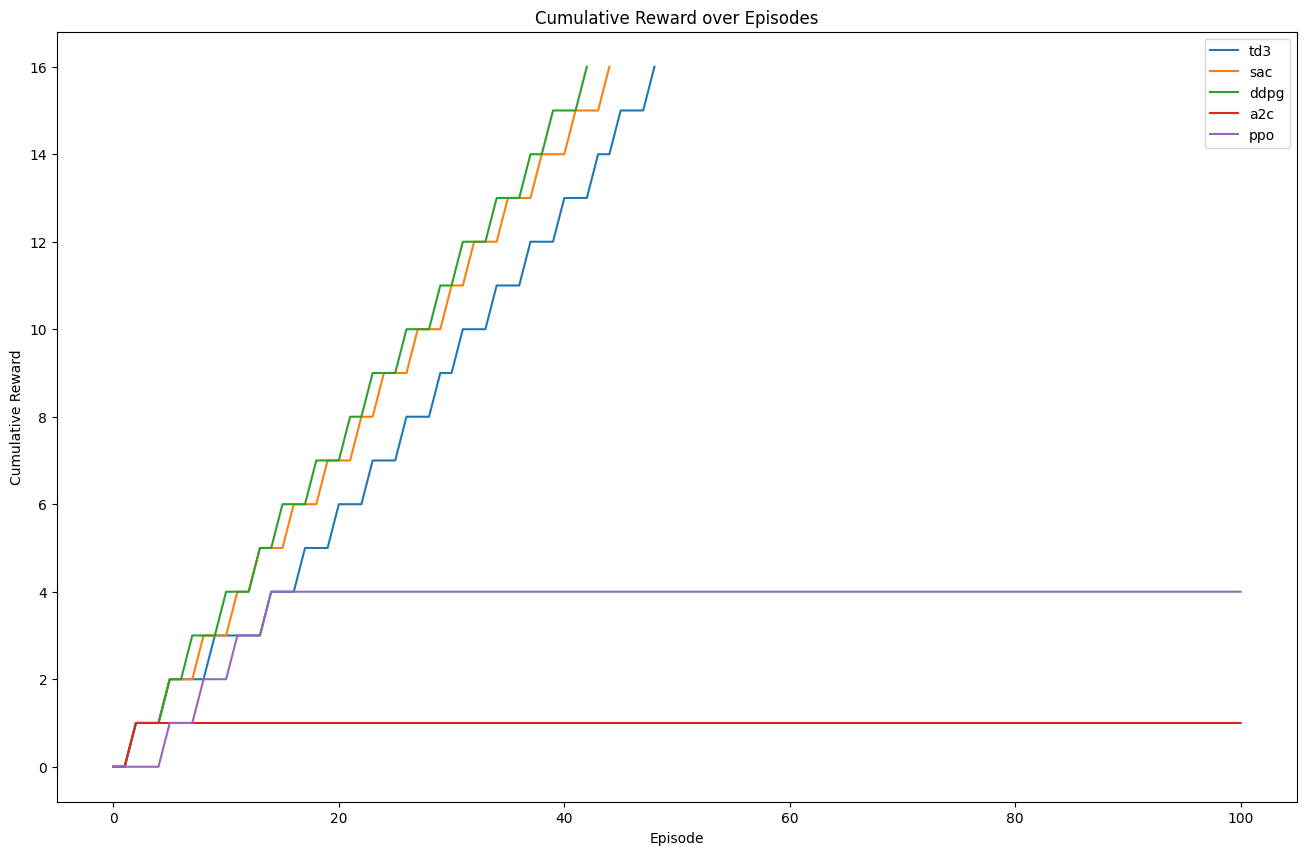

In [33]:
test = gymnasium.make(ENV_ID)
sac = SAC.load("models/sac.zip")
td3 = TD3.load("models/td3.zip")
ddpg = DDPG.load("models/ddpg.zip")
ppo = PPO.load("models/ppo.zip")
a2c = A2C.load("models/a2c.zip")

rewards = {}
rewards["td3"] = run_env(test, td3)
rewards["sac"] = run_env(test, sac)
rewards["ddpg"] = run_env(test, ddpg)
rewards["a2c"] = run_env(test, a2c)
rewards["ppo"] = run_env(test, ppo)

plot_cumulative_rewards(rewards)

## Conclusion <a class="anchor" id="5"></a>

Even though all algorithms have been trained on the same environment with their best found Hyperparameters, only 3 out 5 Algorithms manage to reach the last gate.
- SAC found the last gate after 44 steps
- TD3 found the last gate after 46 steps
- DDPG found the last gate after 43 steps
- A2C and PPO did not complete the environment in 100 or less steps
